# Interferometry Image Reconstruction

This notebook provides a minimal image reconstruction algorithm for interferometry.

Let $I(\alpha, \beta)$ be an image on the sky.
Interferometry allows astronomer to sample the Fourier transform of the image $\hat{I}(u, v) = \int\int I(\alpha,\beta) \exp[-2\pi i(u\alpha + v\beta)] d\alpha d\beta$ along the $uv$-tracks $[u_{ab}(t), v_{ab}(t)]$ for telescopes $a$ and $b$ at time $t$.

Given a small number of telescope locations, we have a sparse set of $uv$ tracks, which sample the Fourier transform of the image.
We call these sampled Fourier coefficients the visibility $V_{abj} = \hat{I}(u_{ab}(t_n), v_{ab}(t_n))$ for all $a$, $b$, and $n$.

The problem of interferometry image reconstruction is to receover the original sky image $I(\alpha, \beta)$ to the best we can, based on the visibility $\{V_{abj}\}$.

We will develop a minimal image reconstruction algorithm in this notebook.
To make the algorithm easier to understand, we will build it incrementally.
We start by importing some useful packages.
In addition to the standard packages, `ehtplot` provides modified `afmhot` colormaps including `afmhot_us`, `afmhot_10us`, etc.

In [1]:
import numpy as np
import pandas as pd

from astropy    import units
from astropy.io import fits

import ehtplot # from https://github.com/liamedeiros/ehtplot
from matplotlib import pyplot as plt

## Sample Data: EHT 2017 M87*

We start by look at a sample data set from EHT's 2017 observation.
The (heavily) averaged data is provided in a simple CSV file.

In [2]:
df = pd.read_csv(
    "vis/SR1_M87_2017_095_hi_hops_netcal_StokesI.csv",
    skiprows=2,
    names=['t', 's1', 's2', 'u', 'v', 'amp', 'phase', 'sigma'])

We also compute the complex visbility and the "weight".

In [3]:
df['V'] = df.amp * np.exp(1j * (df.phase * np.pi / 180))
df['w'] = 1.0 / df.sigma

print(df.V)
print(df.w)

0      -0.006917-0.012507j
1       0.136019+0.013969j
2       0.591577+0.950759j
3      -0.013640-0.012420j
4       0.075689-0.117322j
               ...        
6453    0.310243+0.059955j
6454    0.040855+0.042377j
6455   -0.108554-0.002454j
6456    0.977469-0.554353j
6457   -0.012231+0.104216j
Name: V, Length: 6458, dtype: complex128
0       171.033435
1       201.306479
2       190.730862
3        22.433737
4        30.683656
           ...    
6453     32.841596
6454     11.075692
6455     22.745490
6456     10.884912
6457     34.742742
Name: w, Length: 6458, dtype: float64


and list all the sites during the observation:

In [4]:
print('Sites:', sorted(set(df.s1) | set(df.s2)))

Sites: ['AA', 'AP', 'AZ', 'JC', 'LM', 'PV', 'SM']


The standard visualizations include $(u,v)$ tracks and visibility amplitudes vs baseline distance plots.

In [5]:
def uvtracks(ax, df, lim=9e9):
    u = df['u']
    v = df['v']
    U = np.concatenate([u, -u])
    V = np.concatenate([v, -v])
    ax.scatter(U, V, marker='.')
    ax.set_xlabel(r'$u$ ($\lambda$)')
    ax.set_ylabel(r'$v$ ($\lambda$)')
    ax.set_xlim( lim,-lim)
    ax.set_ylim(-lim, lim)
    ax.set_aspect('equal')

def amp(ax, df, ylog=True):
    a = df['amp']
    u = df['u']
    v = df['v']
    d = np.sqrt(u*u + v*v)
    ax.scatter(d, a, marker='.')
    ax.set_xlabel(r'$(u,v)$ distance ($\lambda$)')
    ax.set_ylabel(r'Visibility amplitude $|V|$')
    if ylog:
        ax.set_yscale('log')

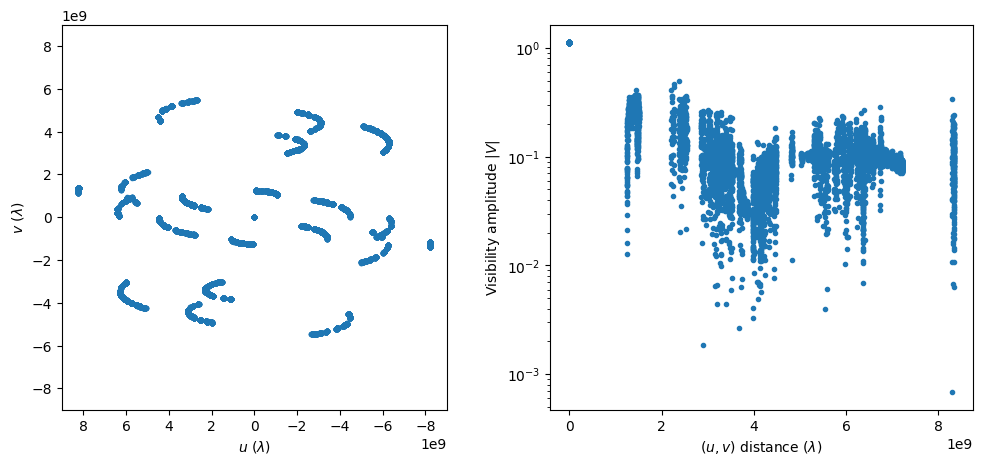

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
uvtracks(axes[0], df)
amp(axes[1], df)

## Sample Reconstruction: EHT 2017 M87*

We then look at a sample reconstruction from EHT's 2017 observation.
The `ehtim` reconstructed image is stored as a `fits` file.
We define a new class `Image` to store both the pixel values and the pixel dimensions.
We also define our own `imshow()` to plot the image.

In [7]:
class Image:
    def __init__(self, file):
        with fits.open(file) as hdul:
            self.p1 = hdul[0].header['CDElT1'] * units.degree.to(units.uarcsec)
            self.p2 = hdul[0].header['CDElT2'] * units.degree.to(units.uarcsec)
            self.I  = hdul[0].section[:,:]

        self.fov1 = self.p1 * self.I.shape[0]
        self.fov2 = self.p2 * self.I.shape[1]

def imshow(ax, img):
    h1 = img.fov1/2
    h2 = img.fov2/2
    ax.imshow(img.I, cmap='afmhot_10us', origin='lower', extent=[-h1,h1,-h2,h2])
    ax.set_xlabel(r'$\alpha$ ($\mu$as)')
    ax.set_ylabel(r'$\beta$ ($\mu$as)')
    ax.set_aspect(r'equal')

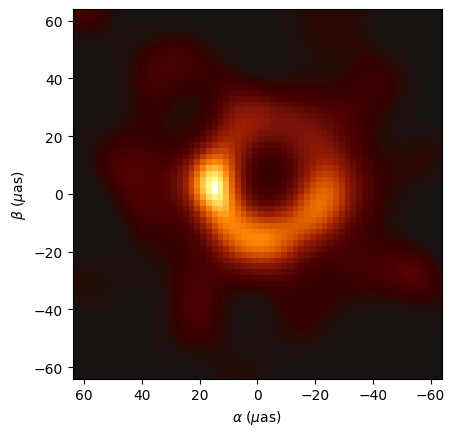

In [8]:
img = Image('img/3597_ehtim.fits')

fig, ax = plt.subplots(1,1)
imshow(ax, img)